## practicalRegress4

**Goal: to perform Gaussian process regression of pose data.**

**TO DO** Run this code!<br/>
**TO DO** Observe what's happening, and if possible, make the code more speed-efficient.<br/>

There's nothing to actually implement in this part of the practical. All the work is done! <br/>

The implementation of Gaussian process regression regresses images of faces against poses. <br/>
The code takes about a minute to run as the dimensionality and number of training examples are both quite high.<br/>
Look through the code and make sure you understand everything it is doing.<br/>
Head pose estimation is a difficult problem - no-one really knows how to solve this yet.<br/>
This method is not quite cutting edge - we can get the mean average error down to ~10 degrees with a different approach.<br/>
Even humans cannot do this very well!

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {   return false;}
//disable auto scroll

<IPython.core.display.Javascript object>

In [6]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy.optimize as optimize
import scipy
from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv, svd
plt.style.use('default')
%matplotlib notebook # %matplotlib inline

UsageError: unrecognized arguments: # %matplotlib inline


In [3]:
#load in training data
tr_data = spio.loadmat('PoseRegressionData.mat')

dataTrain = tr_data['dataTrain']
dataTest = tr_data['dataTest']
dataTrainPP = tr_data['dataTrainPP']
dataTestPP = tr_data['dataTestPP']
poseTrain = tr_data['poseTrain']
poseTest = tr_data['poseTest']


In [4]:
#==========================================================================
# utilities
#==========================================================================

#==========================================================================
#returns log of determinant of matrix efficiently
#The determinant is a very small number so we cannot compute it and then
#take the log as matlab can't represent it.  So this is computed in a sneaky way!
def logDet(A):
    U, L, Vh = svd(A)
    V = Vh.T
    ld = np.sum(np.log(L))
    return ld

#==========================================================================
#returns log of normal pdf
def getLogGaussianLike(w,muParam,covarParam):
    D = w.size
    #L= -0.5*D*log(2*pi)      -0.5*logDet(covarParam)-0.5*(muParam-w)'           *inv(covarParam)*(muParam-w);
    L = -0.5*D*np.log(2*np.pi)-0.5*logDet(covarParam)-0.5*(muParam-w).transpose()@inv(covarParam)@(muParam-w)
    return L

#==========================================================================
#returns negative log marginal likelihood of data
#i.e. marginal likelihood is likelihood after marginalizing over phi
def negLogMarginalLike(sigmaSq,kernelXX,w,sigmaPSq):
    #take exponential as still in log form
    sigmaSq = np.exp(sigmaSq)

    #compute mean and variance parameters
    muParam = np.zeros((w.size,1))
    
    #covarParam = kernelXX*sigmaPSq+sigmaSq*eye(size(kernelXX,2));
    covarParam = kernelXX*sigmaPSq+sigmaSq*np.eye(kernelXX.shape[1])
    
    #return negative log marginal
    L = -getLogGaussianLike(w,muParam,covarParam);
    return L



#==========================================================================
#returns RBF kernel matrix
def kernel(X1_in,X2_in):
    
    lengthScale=3000
    X1=X1_in[:,np.newaxis] if X1_in.ndim==1 else X1_in
    X2=X2_in[:,np.newaxis] if X2_in.ndim==1 else X2_in
        
    I1 = X1.shape[1]
    I2 = X2.shape[1]
    
    #create each row of kernel matrix separately.
    #K = zeros(I1,I2);
    K = np.zeros((I1,I2))
    #for (c1 = 1:I1)
    for c1 in range(I1) :
        #compute distance between this example and all other examples
        #diff = sum( (repmat(X1(:,c1),1,I2)-X2).^2)/lengthScale ; 
        diff = np.sum( (X2-X1[:,[c1]])**2 ,axis=0,keepdims=True ) / lengthScale
        #store in kernel matrix
        K[c1,:] = np.exp(-diff)
        
    return K
#==========================================================================
def estNoiseParameter(dataTrainPP,poseTrain,sigmaPSq):

    #initial estimate for variance
    sigmaSqInit =np.std(poseTrain)

    #take logarithm (so optimizer doesn't have to constrain to be positive)
    sigmaSqInit = np.log(sigmaSqInit)
    
    #precompute kernel so that it doesn't have to repeatedly do this
    kernelXX = kernel(dataTrainPP,dataTrainPP)

    #fit variance of data - this routine finds the value of sigmaSq that
    #minimizes the negative log marginal likelihood
    sigmaSq = optimize.fmin(
        func=lambda sigmaSq:negLogMarginalLike(sigmaSq, kernelXX,poseTrain,sigmaPSq), x0=sigmaSqInit, disp=False)
    
    #exponentiate to return to positive value
    sigmaSq = np.exp(sigmaSq)
    
    return sigmaSq
    

calculating...
calculating nTestData...


C:\Users\86189\AppData\Local\Temp\ipykernel_12788\692796968.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  poseTestPredictMean[cTestData,0] = (sigmaPSq/sigmaSq)*kernel(thisData,dataTrainPP)@poseTrain-(sigmaPSq/sigmaSq)*kernel(thisData,dataTrainPP)@WKXXw
C:\Users\86189\AppData\Local\Temp\ipykernel_12788\692796968.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  poseTestPredictVar[cTestData,0] = sigmaPSq*kernel(thisData,thisData)-sigmaPSq*kernel(thisData,dataTrainPP)@W@kernel(dataTrainPP,thisData)+sigmaSq


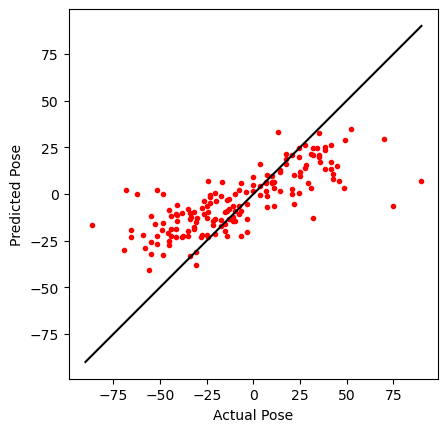

Pearson product moment coefficient = 0.7721363357001315
Mean average error = 17.627853980591723


In [7]:
# reload 
dataTrainPP = tr_data['dataTrainPP']
dataTestPP = tr_data['dataTestPP']

#find size of preprocssed image
imY,imX,I = dataTrainPP.shape

#reshape training data into columns of matrix
dataTrainPP = dataTrainPP.reshape([-1,I])

D,I = dataTrainPP.shape

#define hyperparameter
sigmaPSq = 1000000

print('calculating...')
#The goal of this routine is to take data x and w and the prior variance
sigmaSq = estNoiseParameter(dataTrainPP,poseTrain,sigmaPSq)

#now fit model
#W = inv(kernel(dataTrainPP,dataTrainPP)+(sigmaSq/sigmaPSq)*eye(I));
W = inv(kernel(dataTrainPP,dataTrainPP)+(sigmaSq/sigmaPSq)*np.eye(I))
#WKXXw = W*kernel(dataTrainPP,dataTrainPP)*poseTrain;
WKXXw = W@kernel(dataTrainPP,dataTrainPP)@poseTrain

#find size of test data
imY,imX,nTestData = dataTestPP.shape

#reshape training data into columns of matrix
dataTestPP = dataTestPP.reshape([-1,nTestData])

#for each test data, get mean and variance of prediction
poseTestPredictMean = np.zeros((nTestData,1))
poseTestPredictVar  = np.zeros((nTestData,1))

print('calculating nTestData...')

for cTestData in range(nTestData):
    
    thisData = dataTestPP[:,cTestData]
 
    poseTestPredictMean[cTestData,0] = (sigmaPSq/sigmaSq)*kernel(thisData,dataTrainPP)@poseTrain-(sigmaPSq/sigmaSq)*kernel(thisData,dataTrainPP)@WKXXw
    poseTestPredictVar[cTestData,0] = sigmaPSq*kernel(thisData,thisData)-sigmaPSq*kernel(thisData,dataTrainPP)@W@kernel(dataTrainPP,thisData)+sigmaSq

#draw figure of predictions vs. ground truth
fig=plt.figure()
plt.plot(poseTest,poseTestPredictMean,'r.')
fig.axes[0].set_xlim(-90,90)
fig.axes[0].set_ylim(-90,90)
plt.xlabel('Actual Pose')
plt.ylabel('Predicted Pose')
plt.plot([-90,90],[-90,90],'k-')
plt.axis('square')
plt.show()

#compute statistics of how well we have done
covMat = np.cov(np.vstack([poseTest.transpose(),poseTestPredictMean.transpose()]))
PPMCC  = covMat[1,0]/np.sqrt(covMat[0,0]*covMat[1,1])
MAE = np.mean(np.abs(poseTest-poseTestPredictMean))

print('Pearson product moment coefficient = {:}'.format(PPMCC))
print('Mean average error = {:}'.format(MAE))


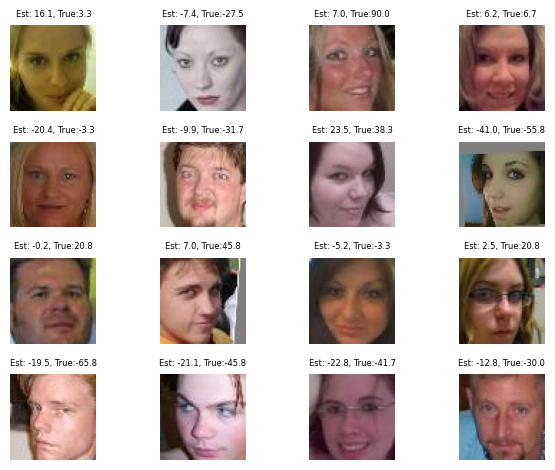

In [8]:
#draw some of the data
nTestData =dataTest.shape[3]
randOrder = np.random.permutation(nTestData)
#randOrder = np.arange(20)

f, axarr = plt.subplots(4, 4);
for cData in range(16):
    axarr[int(cData/4),int(cData%4)].imshow(dataTest[:,:,:,randOrder[cData]].astype(np.uint8))
    axarr[int(cData/4),int(cData%4)].axis('off')
    axarr[int(cData/4),int(cData%4)].set_title( 'Est: {:2.1f}, True:{:2.1f}'.format(
                poseTestPredictMean[randOrder[cData],0],poseTest[randOrder[cData],0] ), size=6 )

plt.tight_layout()
